# Explainable State-of-Health Estimation for Lithium‑Ion Batteries

## Import neccessary packages

In [3]:
import  os
import pandas as pd
import numpy as np
from Scripts.Train_Eval_Func import train_model, evaluate_regression
from Scripts.Dataset_Class import create_dataloaders_from_separate_sets
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from Scripts.CNN_Class import MultiSource1DCNN
from Scripts.Data_Preprocess import Data_Preprocess
from Scripts.Multi_Func import train_model, evaluate_regression, intgrads_map

## Data Preprocess

In [ ]:
# Obtain the training, testing, and validation data and labels
Train_EIS, Train_Capacity, Test_EIS, Test_Capacity, Val_EIS, Val_Capacity = Data_Preprocess()

## Train Model

Using device: cuda
Epoch 1/1500 — Train Loss: 0.0694, Val Loss:   0.0283
Validation loss improved. Saving model (epoch 1).
Epoch 2/1500 — Train Loss: 0.5248, Val Loss:   0.0944
Epoch 3/1500 — Train Loss: 0.1336, Val Loss:   0.0578
Epoch 4/1500 — Train Loss: 0.6778, Val Loss:   0.1414
Epoch 5/1500 — Train Loss: 0.0313, Val Loss:   0.0626
Epoch 6/1500 — Train Loss: 0.0452, Val Loss:   0.0347
Epoch 7/1500 — Train Loss: 0.1399, Val Loss:   0.0742
Epoch 8/1500 — Train Loss: 0.1208, Val Loss:   0.0526
Epoch 9/1500 — Train Loss: 0.0072, Val Loss:   0.0445
Epoch 10/1500 — Train Loss: 0.0020, Val Loss:   0.0431
Epoch 11/1500 — Train Loss: 0.0013, Val Loss:   0.0399
Epoch 12/1500 — Train Loss: 0.0012, Val Loss:   0.0382
Epoch 13/1500 — Train Loss: 0.0012, Val Loss:   0.0403
Epoch 14/1500 — Train Loss: 0.0011, Val Loss:   0.0412
Epoch 15/1500 — Train Loss: 0.0011, Val Loss:   0.0392
Epoch 16/1500 — Train Loss: 0.0011, Val Loss:   0.0388
Epoch 17/1500 — Train Loss: 0.0010, Val Loss:   0.0414
Epoch

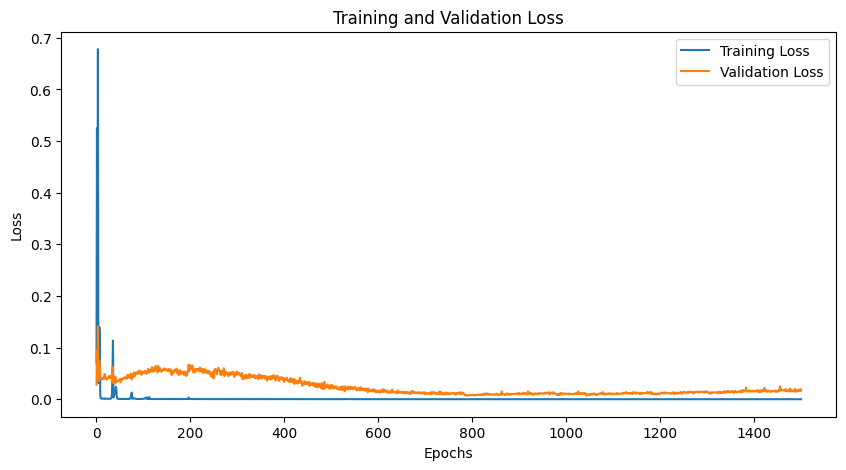

MSE on test set: 0.0145
R2 score on test set: -0.6064
Model saved to 'cnn_model.pth'


In [56]:
# Parameter settings
seq_len = 60
num_sources = 4
batch_size = 32
learning_rate = 0.0001
num_epochs = 1000

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
# Create three separate datasets - training set, validation set, and test set
# Replace with actual data and labels in practical use
# Example data - replace with real data in actual applications

# Use the new function to create separate data loaders
train_loader, val_loader, test_loader = create_dataloaders_from_separate_sets(
    train_data=Train_EIS,
    train_labels=Train_Capacity,
    val_data=Val_EIS,
    val_labels=Val_Capacity,
    test_data=Test_EIS,
    test_labels=Test_Capacity,
    is_classification=False,  # Set as a regression task
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_val=False,
    shuffle_test=False,
    random_state=42
)

# Build the model
model = MultiSource1DCNN(
    seq_len=seq_len,
    num_sources=num_sources,
    conv_channels=(16, 32, 64),
    kernel_sizes=(3, 3, 3),
    fc_hidden=128,
    num_classes=1  # Output dimension is 1 for regression
)

# Train the model
train_losses, val_losses, model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, device=device, learning_rate=learning_rate)

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_curve.png')
plt.show()

# Evaluate the model
mse, r2 = evaluate_regression(model, test_loader, device)

# Save the model
torch.save(model.state_dict(), 'cnn_model.pth')
print("Model saved to 'cnn_model.pth'")


## Explain the model

### Load the model

In [12]:
# 1. Instantiate a model with the same architecture
model = MultiSource1DCNN(
    seq_len=60,
    num_sources=4,
    conv_channels=(16, 32, 64),
    kernel_sizes=(3, 3, 3),
    fc_hidden=128,
    num_classes=1
)

# 2. Select the device for mapping (use map_location='cpu' if only CPU is available or desired;
#    use map_location='cuda:0' to load onto GPU if trained and run on GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3. Load the weights file
state_dict = torch.load('Model/cnn_model.pth', map_location=device)

# 4. Load the weights into the model
model.load_state_dict(state_dict)

# 5. Switch to evaluation mode
model.eval()


MultiSource1DCNN(
  (branch): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU(inplace=True)
  )
  (branches): ModuleList(
    (0-3): 4 x Sequential(
      (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU(inplace=True)
      (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU(inplace=True)
      (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): ReLU(inplace=True)
    )
  )
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

## Integrated Gradients Map

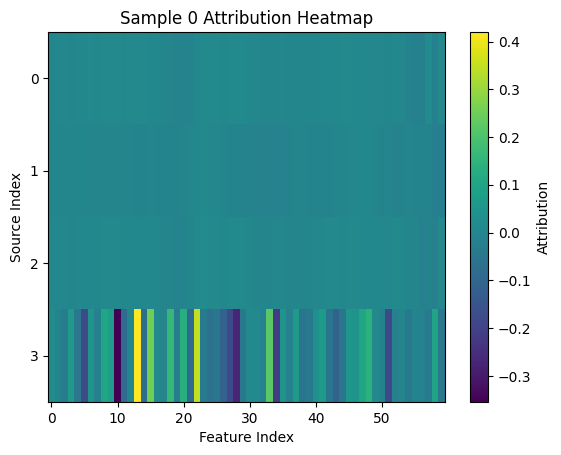

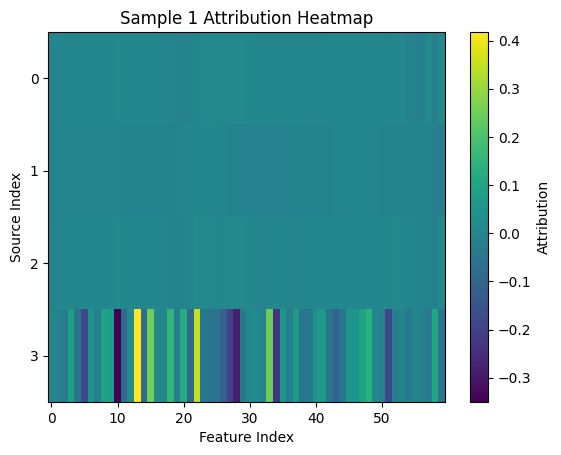

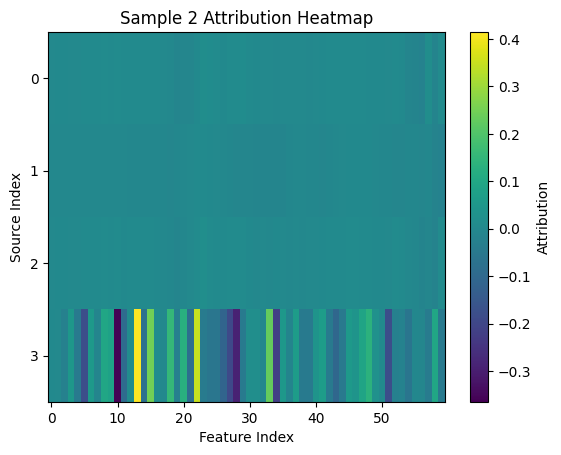

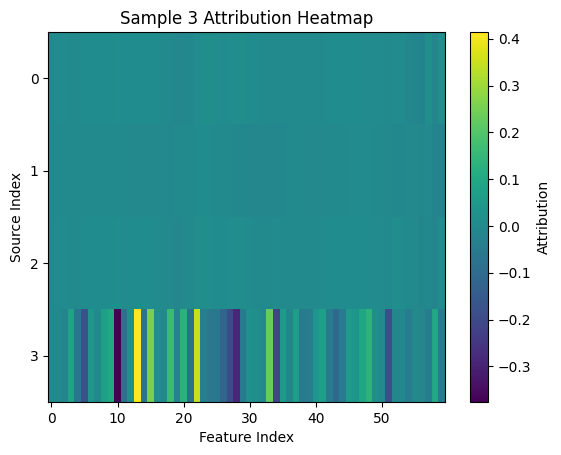

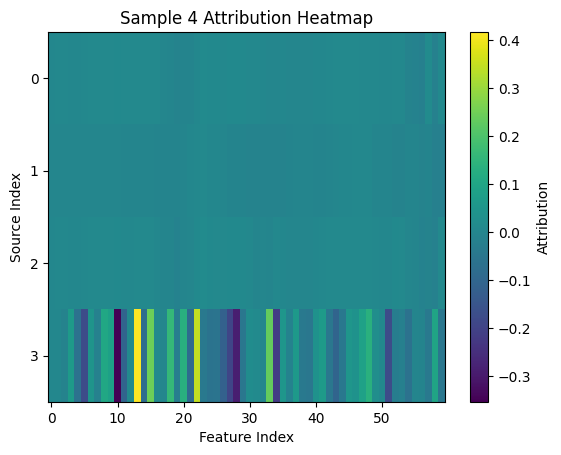

In [19]:
# Generate attribution maps using Integrated Gradients (for the first 5 test samples)
attributions, deltas = intgrads_map(model, torch.from_numpy(Test_EIS[:5, :, :]).float().to(device))

# Visualize attribution heatmaps for each sample
for i in range(min(5, attributions.shape[0])):
    attr = attributions[i].detach().cpu().numpy()  # shape = (n_sources, 60)
    n_sources = attr.shape[0]

    plt.figure()
    plt.imshow(attr, aspect="auto")
    plt.title(f"Sample {i} Attribution Heatmap")
    plt.colorbar(label="Attribution")

    # Set y-axis ticks to 0, 1, ..., n_sources - 1 to represent different sources
    plt.yticks(
        np.arange(n_sources),     # Tick positions
        np.arange(n_sources)      # Tick labels
    )
    plt.xlabel("Feature Index")
    plt.ylabel("Source Index")
    plt.show()

This heatmap visualizes feature attributions for a single sample (Sample 0). The x-axis represents different feature indices, while the y-axis shows source indices (e.g., channels or input segments). Bright colors (yellow) indicate high positive attribution, dark colors (purple) represent negative attribution, and teal indicates near-zero contribution. Notably, only source index 3 shows significant attribution activity, suggesting it is the most influential input source for the model’s output in this sample.